# Comaparing observational and galaxy properties

Notebook contributed by Neha Joshi (@nehapjoshi)

This notebook looks at observational properties of the galaxies in the Run1.2i, Run1.2p, or Run2.1 catalogs.  By splitting the observational property plots into percentiles and plotting a galaxy property with each percentile as a separate curve, trends and dependencies on observational properties can be seen.  Ideally, the curves for all percentiles in the galaxy property plots should match and show that the observational property does not affect what we see.

Some properties may be problematic:
- Blendedness is used as an observational property to include it, but due to the inherent physical blendedness of an object and its surroundings, it is not solely observational.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import GCRCatalogs
from GCR import GCRQuery
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [2]:
#Define catalog name
catalog_name = 'dc2_object_run2.1i_dr1b'

#A reasonable magnitude cut to ensure all galaxies are well detected
max_mag_i = 25.0

#Define tract range for plots here
max_tract = 4441
min_tract = 4429

In [3]:
#Load catalogs here
catalog = GCRCatalogs.load_catalog(catalog_name)

In [4]:
#Define necessary cuts to galaxy properties:
properties_cuts = [
    GCRQuery('mag_i_cModel < %f'%max_mag_i)
]

# Establish some basic cuts intended to yield a galaxy sample with reasonable flux measurements.
basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects (primarily galaxies)
    GCRQuery((np.isfinite, 'mag_i_cModel')),  # Select objects that have i-band cmodel magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'),                                      # Flag for bad centroid measurement
]

In [5]:
#Define what properties we want to look at for the observational and galaxy arrays:
quantities = ['blendedness', 'psf_fwhm_i', 'IxxPSF_i', 'IyyPSF_i', 'IxyPSF_i',
              'mag_g_cModel', 'mag_i_cModel', 'mag_r_cModel', 'x', 'y']

In [6]:
#Apply cuts to catalog and get the wanted sample:
data = catalog.get_quantities(quantities,
                              filters=basic_cuts+properties_cuts, 
                              native_filters=['tract <= %d' %max_tract, 
                                              'tract >= %d' %min_tract])

In [7]:
#find value of |e| PSF using the given data for each galaxy
Ixx = data['IxxPSF_i']
Iyy = data['IyyPSF_i']
Ixy = data['IxyPSF_i']

e1 = (Ixx-Iyy)/(Ixx+Ixy)
e2 = (2*Ixy)/(Ixx+Iyy)
e_psf = (e1**2+e2**2)**0.5

#define colors
gr = data['mag_g_cModel'] - data['mag_r_cModel']
ri = data['mag_r_cModel'] - data['mag_i_cModel']

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in subtract


In [8]:
#Function that plots and splits the data
def plot_split(obs_data, gal_data, obs_title, gal_title, obs_xaxis, gal_xaxis):
    min_obs, max_obs = np.percentile(obs_data,(1,99))
    nbins = 100

    #plotting observational data:
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    myrange = [min_obs,max_obs]
    plt.title(obs_title)
    plt.hist(obs_data, nbins, range=myrange, histtype='step',
            linewidth=2.0, density=True)
    plt.xlabel(obs_xaxis)
    plt.yscale('log')
    
    #setting up quartiles
    quartiles = np.percentile(obs_data,(1,25,50,75,99))
    plt.axvline(quartiles[1])
    plt.axvline(quartiles[2])
    plt.axvline(quartiles[3])
    
    min_gal, max_gal = np.percentile(gal_data,(1,99))
    
    #plotting observational data
    plt.subplot(122)
    labels = ['',
            '1st quartile',
             '2nd quartile',
             '3rd quartile',
             '4th quartile']
    
    myrange = [min_gal,max_gal]
    plt.title(gal_title)
    for q in range(1,len(quartiles)):
        data = gal_data[(obs_data<quartiles[q]) & (obs_data>=quartiles[q-1])]
        plt.hist(data, nbins, range=myrange, 
                 histtype='step', label=labels[q], linewidth=2.0, density=True)
    plt.legend(loc='upper right')
    plt.xlabel(gal_xaxis)
    plt.yscale('log')
    

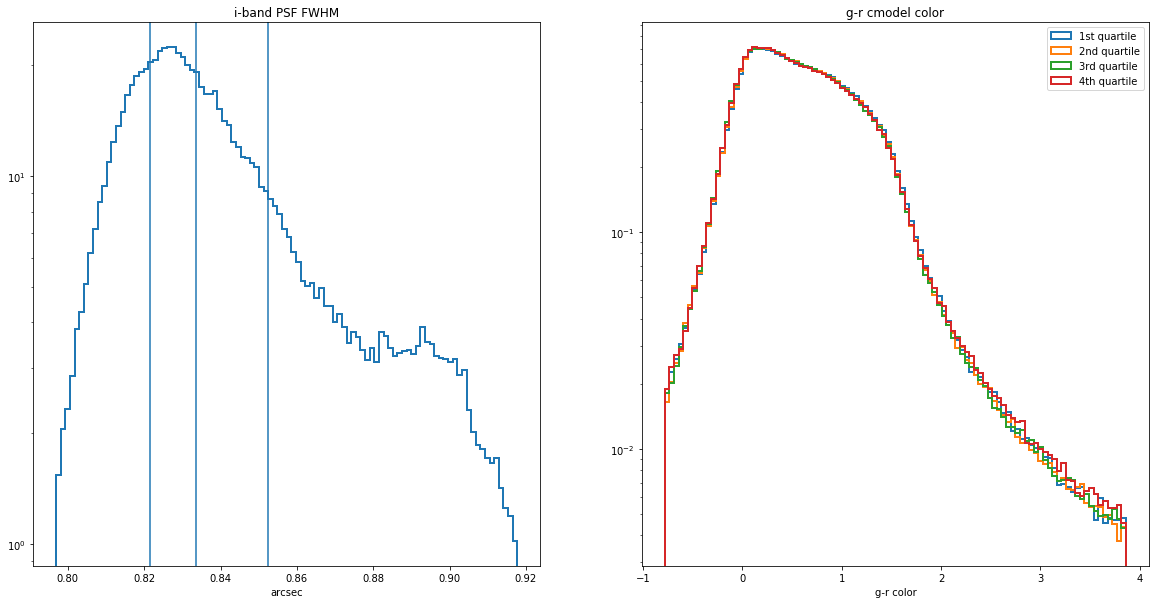

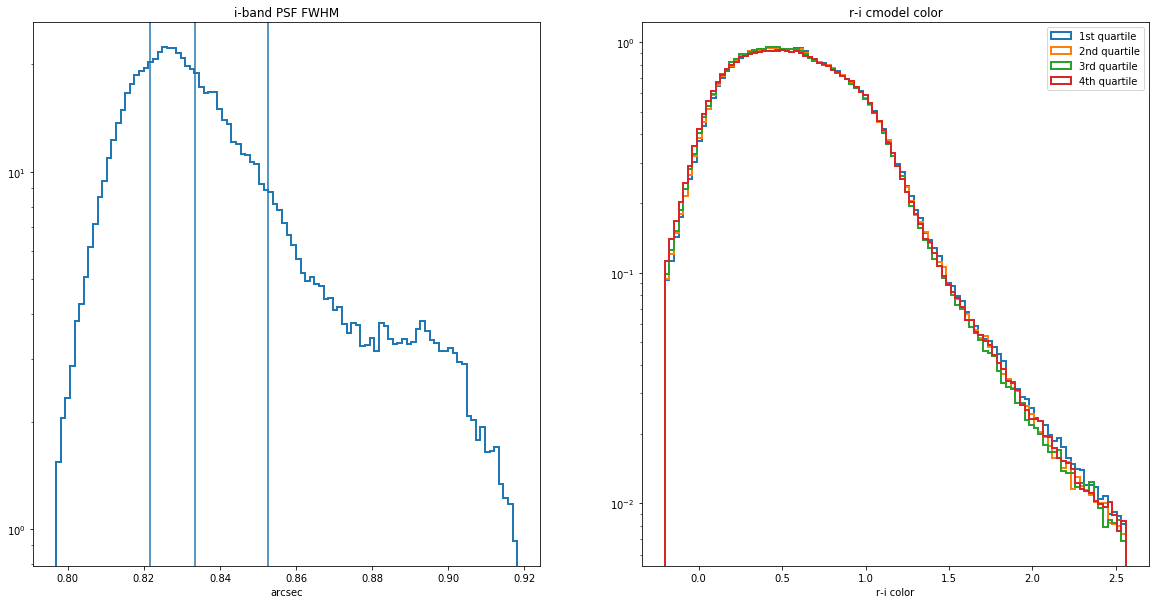

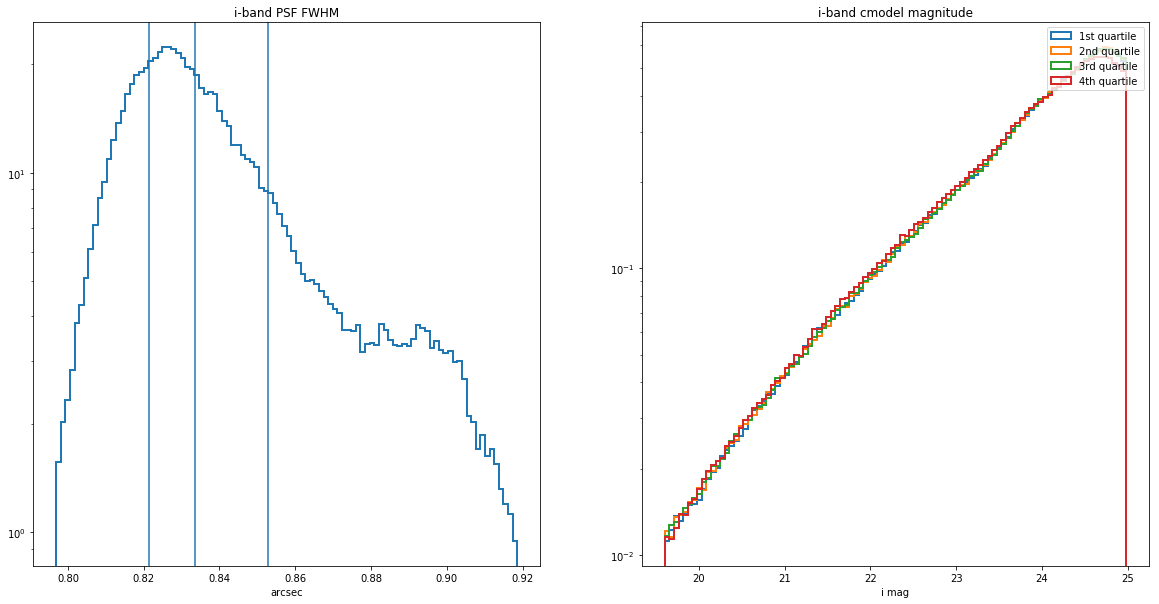

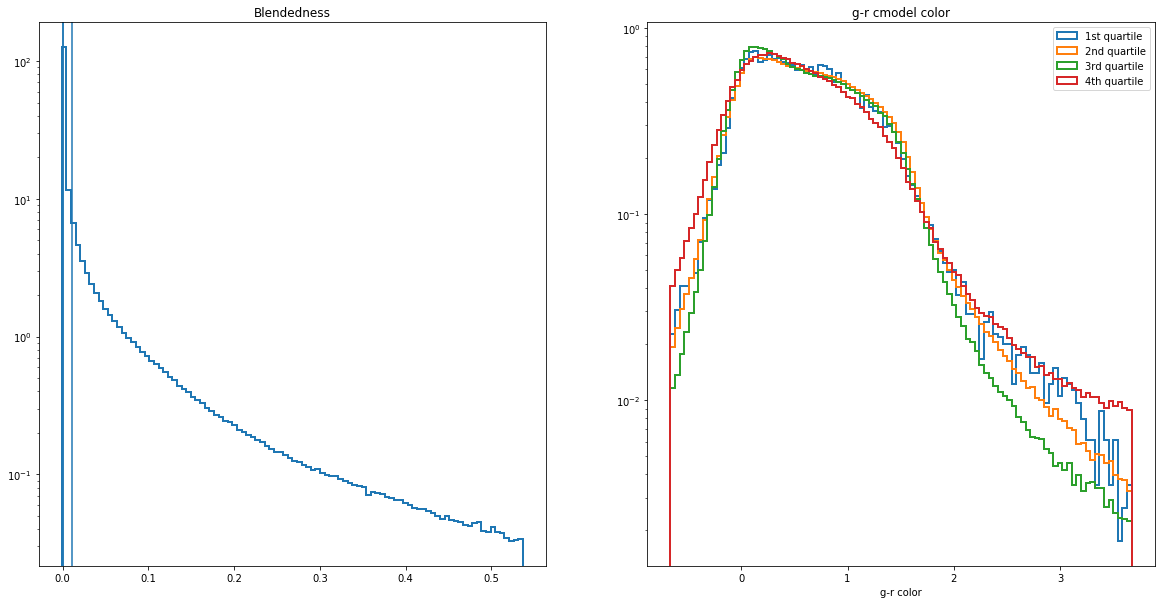

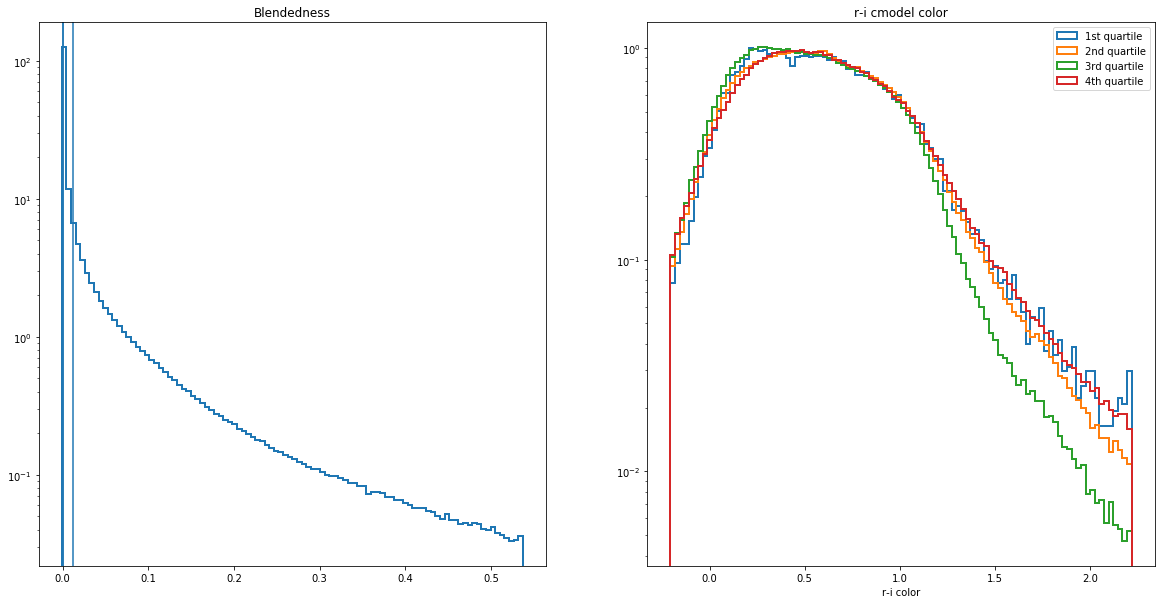

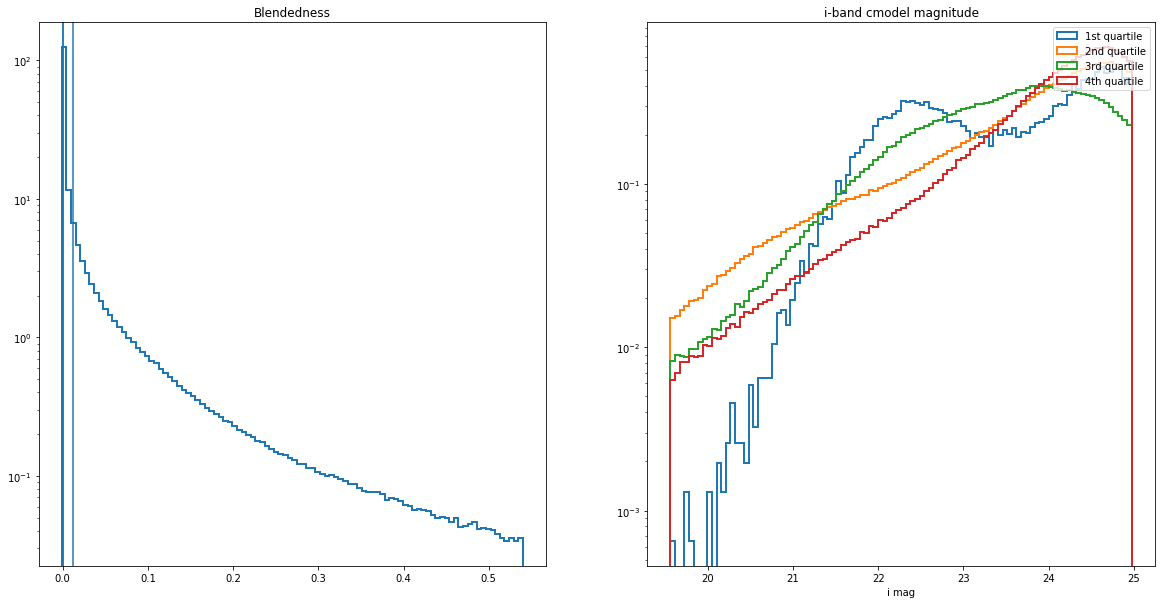

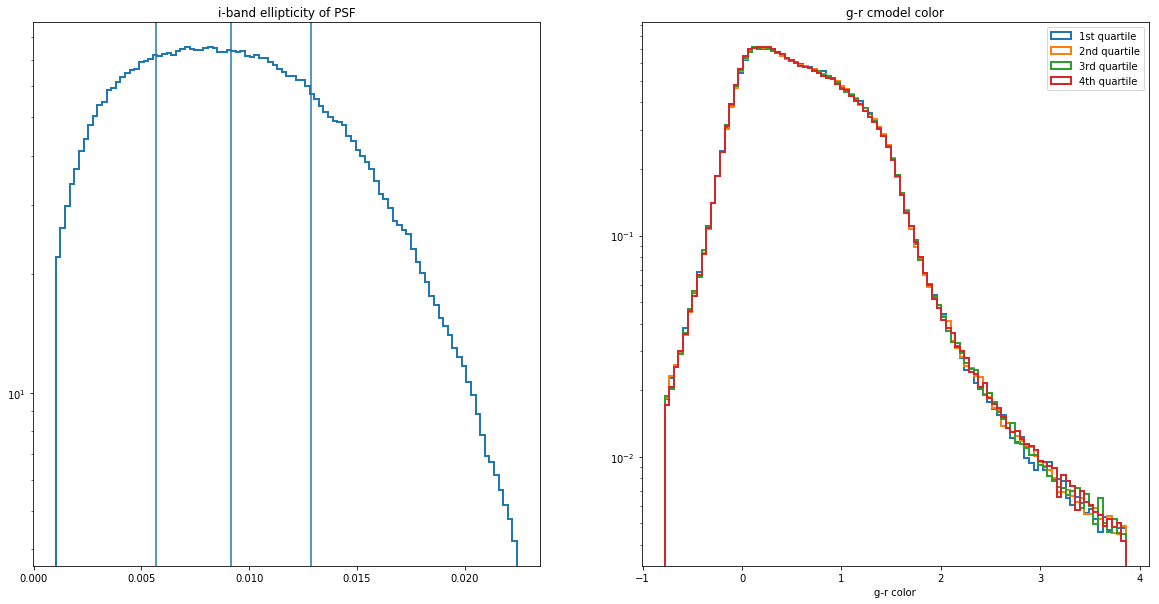

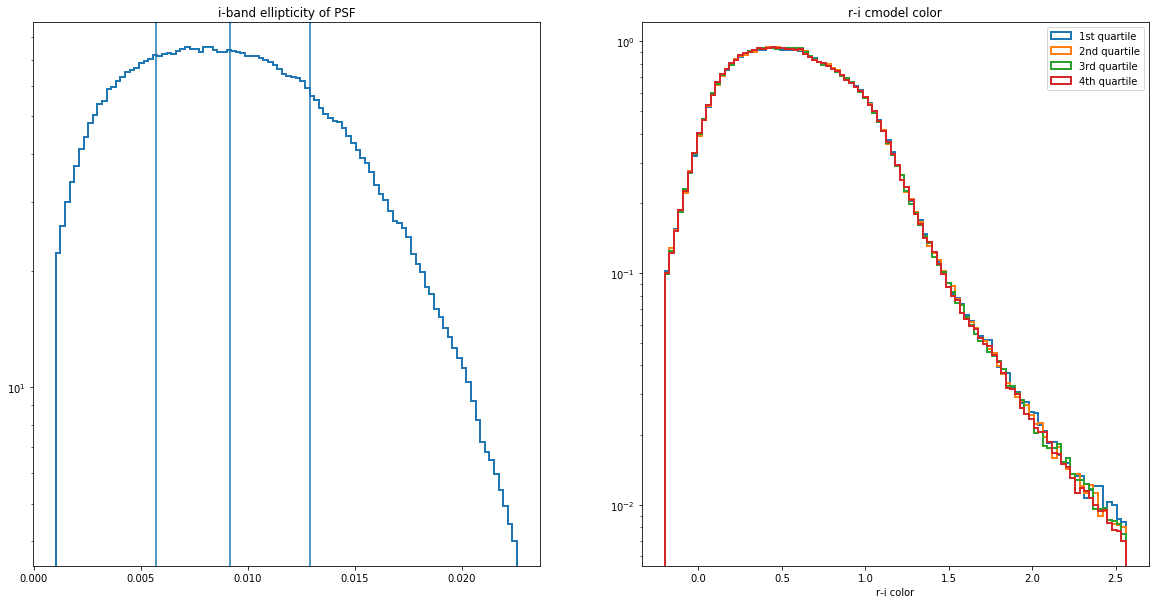

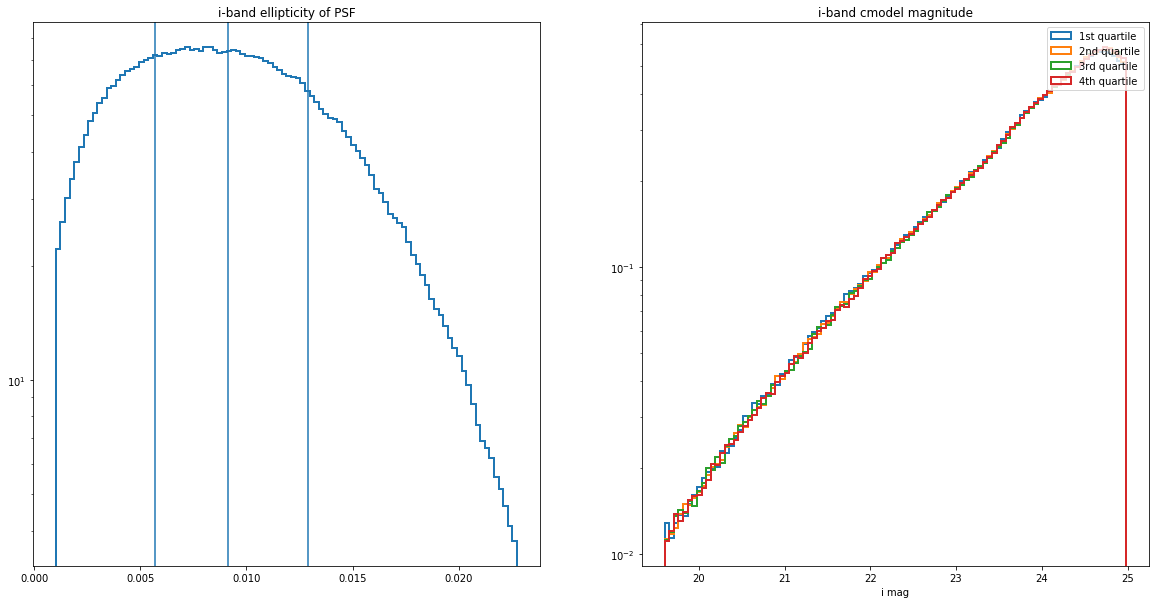

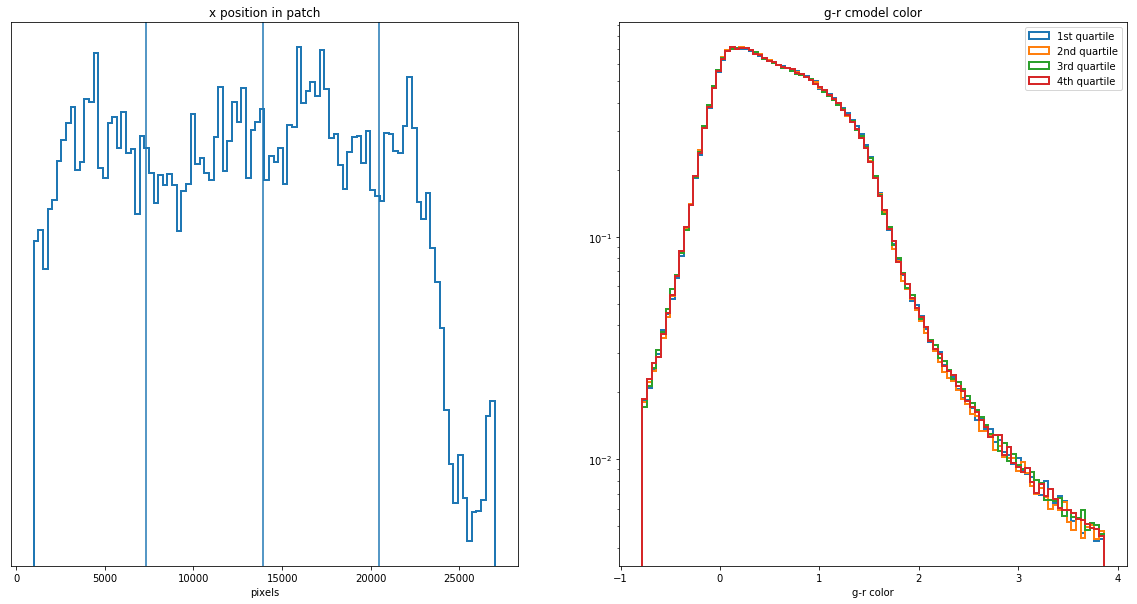

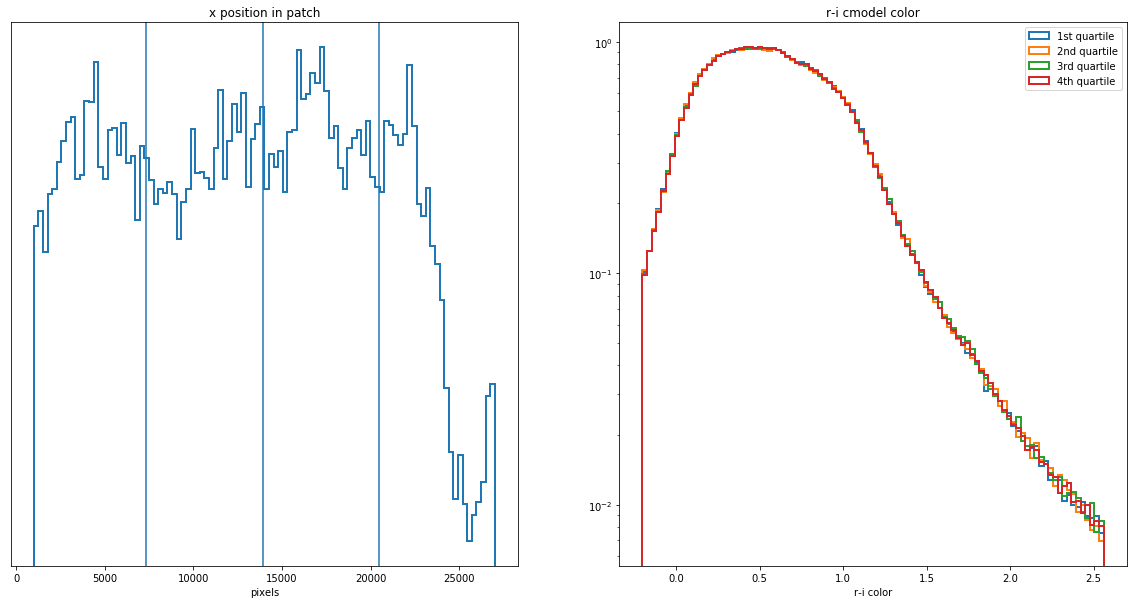

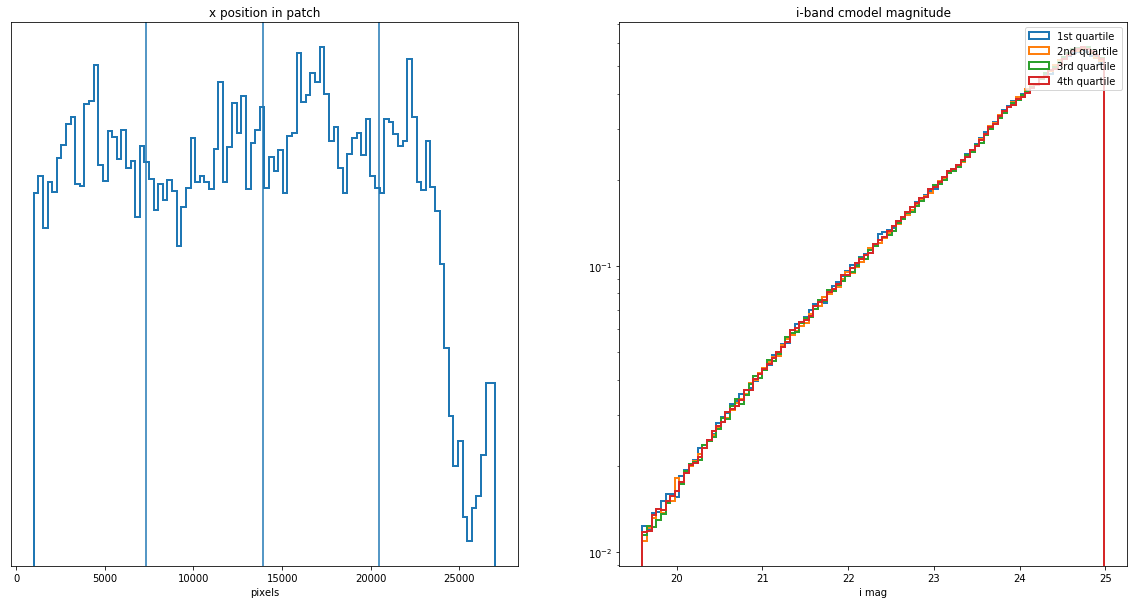

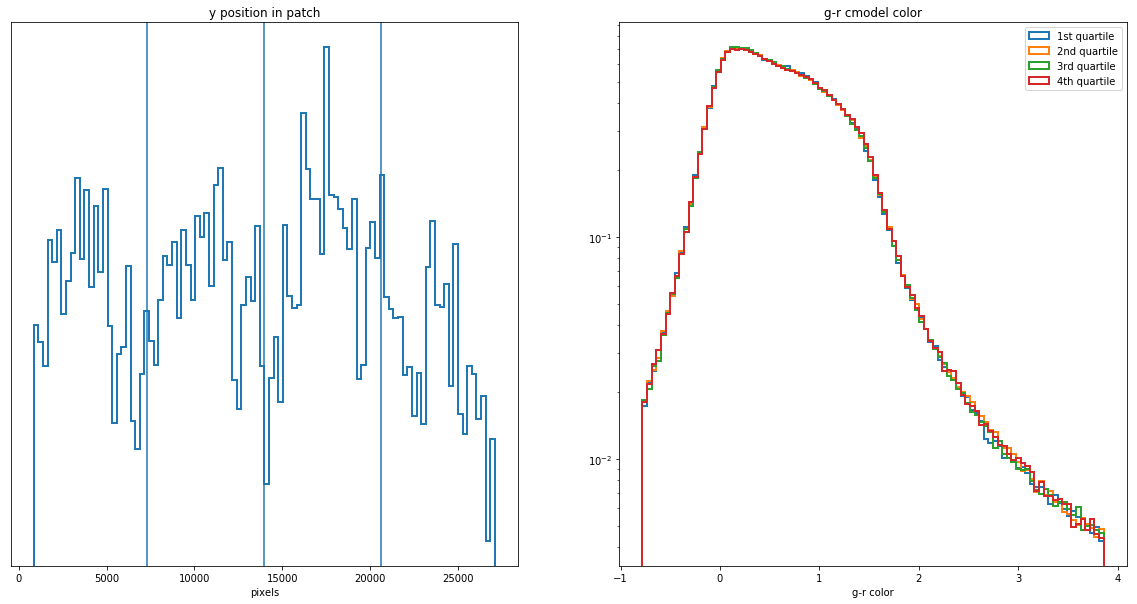

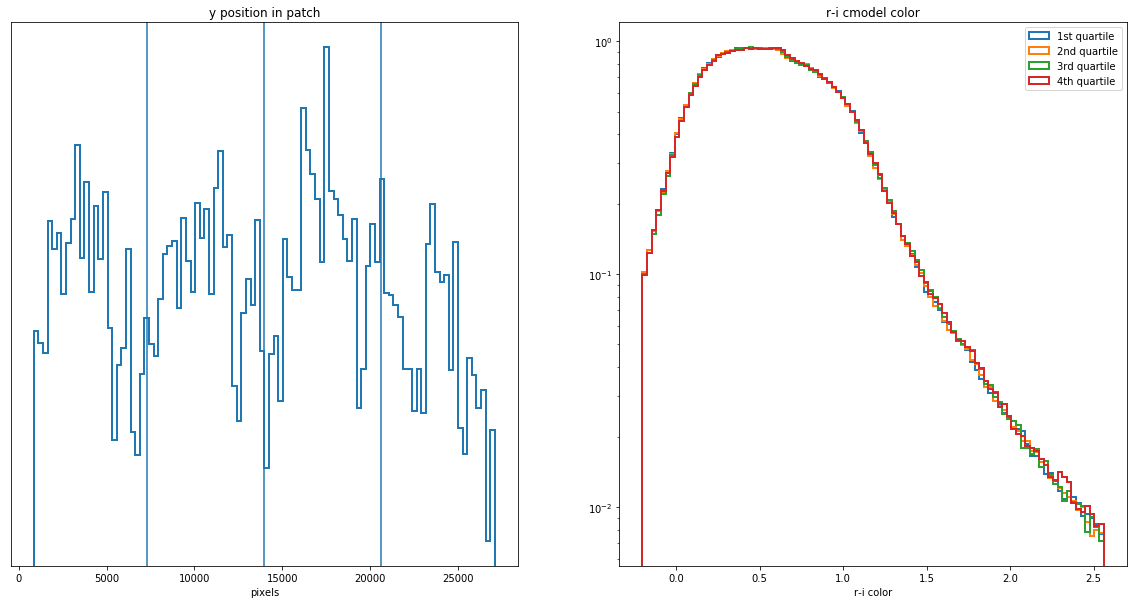

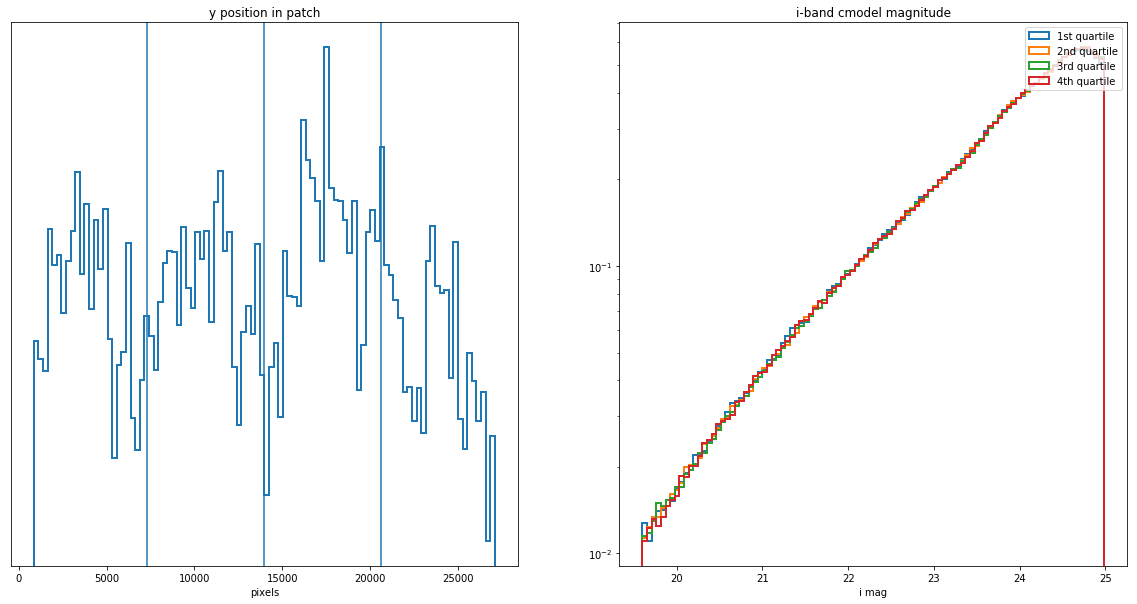

In [9]:
#Define which observational and galaxy properties will be needed for plots, along with titles and axis labels
obs_data = [data['psf_fwhm_i'], data['blendedness'], e_psf, data['x'], data['y']]
gal_data = [gr, ri, data['mag_i_cModel']]
obs_titles = ['i-band PSF FWHM','Blendedness', 'i-band ellipticity of PSF', 'x position in patch', 'y position in patch']
gal_titles = ['g-r cmodel color', 'r-i cmodel color', 'i-band cmodel magnitude']
obs_xaxis = ['arcsec', '', '','pixels','pixels']
gal_xaxis = ['g-r color', 'r-i color', 'i mag']

#make all pairs of observation and galaxy properties to plot
for obs in range(len(obs_data)):
    for gal in range(len(gal_data)):
        good_data = ~np.isnan(obs_data[obs]) & ~np.isnan(gal_data[gal])
        plot_split(obs_data[obs][good_data],gal_data[gal][good_data],
                   obs_titles[obs], gal_titles[gal], 
                   obs_xaxis[obs], gal_xaxis[gal])